## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3 (30 pkt.)
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: twoje imię i nazwisko + numer indeksu

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

'pip' is not recognized as an internal or external command,
operable program or batch file.


### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gym.openai.com/envs/CartPole-v1) i `LunarLander` (https://gym.openai.com/envs/LunarLander-v2/).

In [97]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gymnasium as gym
import pandas as pd
import numpy as np

# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, term, trunc, _= env.step(action)
    # print(term, trunc)
    done = term or trunc

    if done:
        observation = env.reset()
env.close()

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


In [98]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Rozmiar wektora reprezntującego stany: (8,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [ 0.17772226  0.08290938  0.31622574 -1.3600332  -0.22217397  0.03699143
  0.          0.        ]
Przestrzeń akcji: Discrete(4)
Ilość możliwych akcji: 4


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [4]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [78]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards, eps, roll):
    fig, ax = plt.subplots()
    ax.margins(x=0)
    ax.plot(rewards)
    ax.plot(pd.Series(rewards).rolling(roll).mean())
    ax2 = ax.twinx()
    ax2.plot(eps, label='epsilon', color='k')
    #ax2.plot(alpha, label='alpha', color='b')
    ax2.legend(loc='lower left')
    ax2.grid(False)
    ax2.set_ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000, target=None, target_window=None):
    rewards = []
    eps = []
    roll = target_window or 50
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        eps.append(agent.ε)

        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards, eps, roll)
            
        if plot and  target is not None and len(rewards) > target_window and np.mean(rewards[-target_window:]) > target:
            print('early stopping...')
            plot_rewards(rewards, eps, roll)
            break

    return rewards    

In [6]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

AttributeError: 'RandomAgent' object has no attribute 'epsilon'

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Obserwujemy spadek jakości ze względu na zmiany współczynników alpha i epsilon, które stają się coraz mniejsze w celu znalezienia lepszej polityki i mogą pogorszyć uzyskane dobre wyniki. Możemy temu zaradzić poprzez zakończenie uczenia po osiągnięciu satysfakcjonujących rezultatów. Kryterium jakości może być np. przekroczenie określonego celu przez ostatnie *n* epizodów.

In [92]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, γ=0.5, α=0.3, ε=0.3, α_decay=0.999, ε_decay=0.999, α_min=0, ε_min=0):
        super().__init__(env)
        self.γ = γ
        self.ε, self.ε_decay, self.ε_min = ε, ε_decay, ε_min
        self.α, self.α_decay, self.α_min = α, α_decay, α_min
        
        self.buckets = np.array([10, 10, 20, 20])
        self.upper_bounds = np.array([4.8, 2, 0.4, 2])
        self.lower_bounds = -self.upper_bounds
        
        dims = tuple(self.buckets.astype(int))
        np.random.seed(None)
        self.Q = np.random.random_sample((*dims, env.action_space.n))
    
    def process_transition(self, observation, action, reward, next_observation, done):
        a, r, s, s_next = action, reward, self.discrete(observation), self.discrete(next_observation)
        if done:
            self.Q[s_next] = 0
            # self.ε = max(self.ε_min, self.ε * self.ε_decay)
            # self.α = max(self.α_min, self.α * self.α_decay)
        self.Q[s][a] += self.α * (r + self.γ*np.max(self.Q[s_next]) - self.Q[s][a])
        
    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.ε:
            return np.random.randint(self.action_space.n)
        s = self.discrete(observation)
        a = np.argmax(self.Q[s])
        return a
        
    def discrete(self, s):
        return tuple(self.bucketize(s, self.lower_bounds, self.upper_bounds, self.buckets))
    
    @staticmethod
    def bucketize(x, lb, ub, n):
        x = (np.clip(x[0] / (1 - 1/n), lb, ub) - lb)/(ub - lb)
        return np.round((n-1)*x).astype(int)

In [88]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, alpha=0.9, gamma=0.5, epsilon=0.9, eps_decay=0.9999, alpha_decay=0.9999):
        super().__init__(env)
        self.alpha, self.gamma, self.epsilon, self.eps_decay, self.alpha_decay = alpha, gamma, epsilon, eps_decay, alpha_decay
        self.maxes = np.array([4.8, 10, 0.42, 10])
        self.ranges = np.array([30, 30, 50, 50])
        self.mins = -self.maxes
        np.random.seed(123)
        # print([env.action_space.n])
        self.Q = np.random.uniform(low=0, high=3, size=(np.concatenate([self.ranges, [env.action_space.n]])))
        # print(self.Q)
    
    def discretize(self, obs, bin=10):
        obs = obs[0]
        # print(obs)
        discrete_series = (np.clip(obs, self.mins, self.maxes) - self.mins) / (self.maxes - self.mins)
        discrete_series = np.round((self.ranges - 1) * discrete_series)
        # discrete_series = obs / self.maxes + np.array([15, 10, 1, 10])
        return tuple(discrete_series.astype(int))


    def process_transition(self, observation, action, reward, next_observation, done):
        s, s_next = self.discretize(observation), self.discretize(next_observation)
        if done:
            self.epsilon = max(self.epsilon * self.eps_decay, 0)
            # self.alpha = max(self.alpha * self.alpha_decay, 0)
        max_future_q = np.max(self.Q[s_next])
        current_q = self.Q[s + (action,)]
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        self.Q[s + (action,)] = new_q
        # self.Q[s][action] += self.alpha * (reward + self.gamma * np.max(self.Q[s_next]) - self.Q[s][action])
        
    def get_action(self, observation, learning):
        if np.random.random() > self.epsilon:
            s = self.discretize(observation)
            a = np.argmax(self.Q[s])
        else:
            a = np.random.randint(self.action_space.n)
        return a

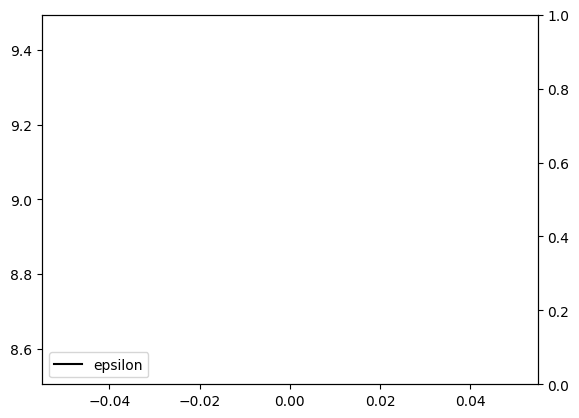

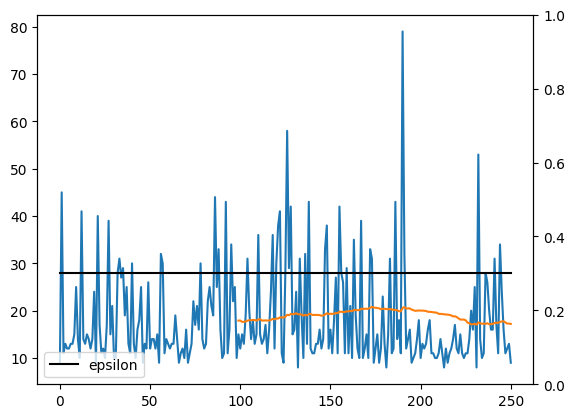

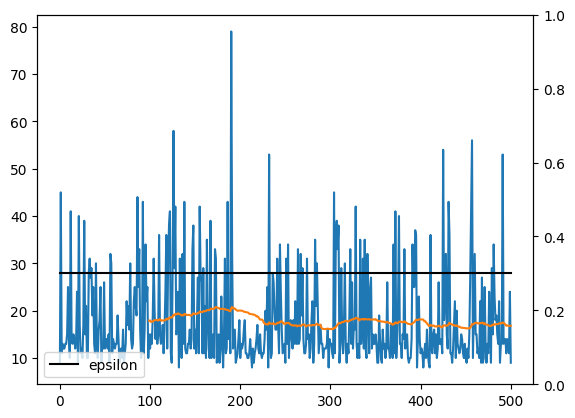

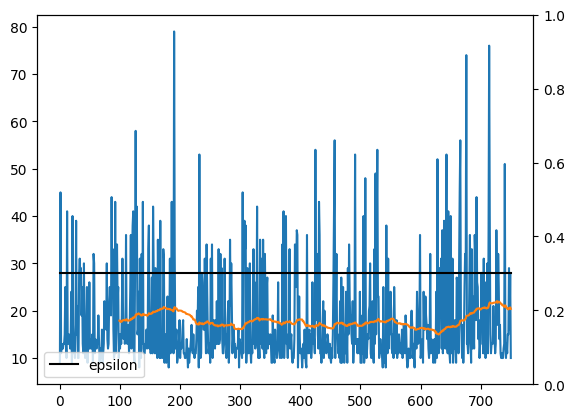

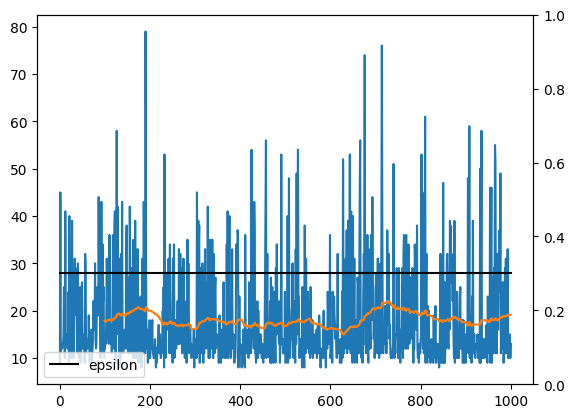

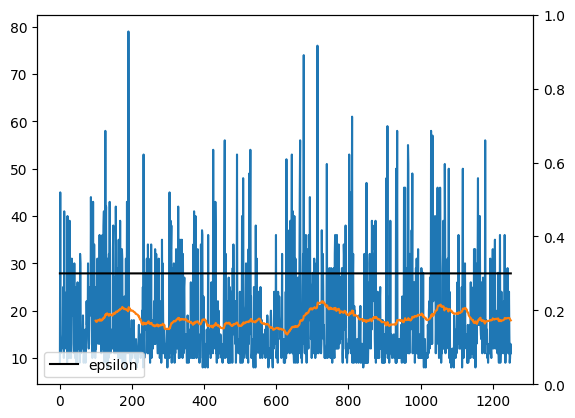

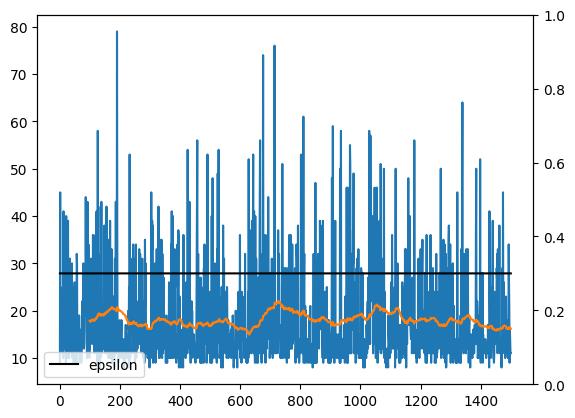

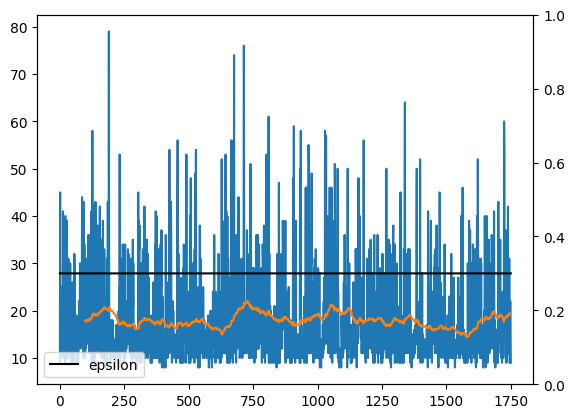

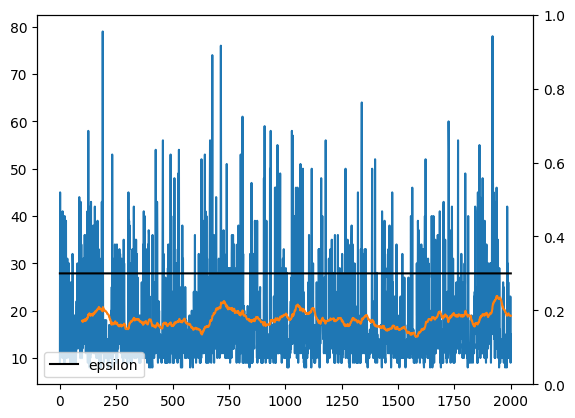

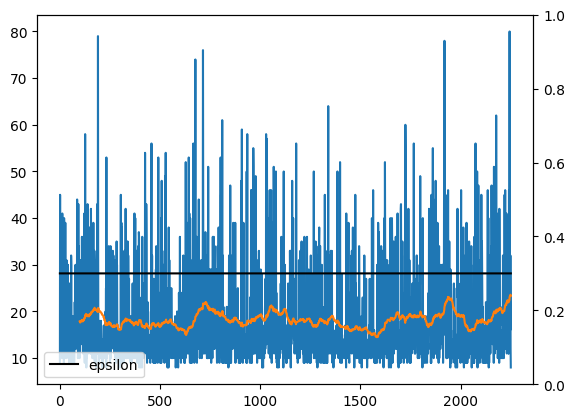

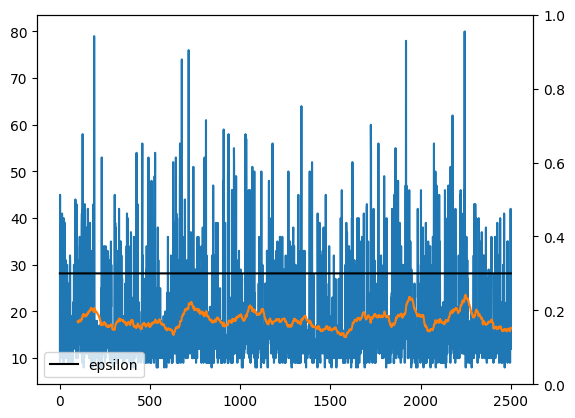

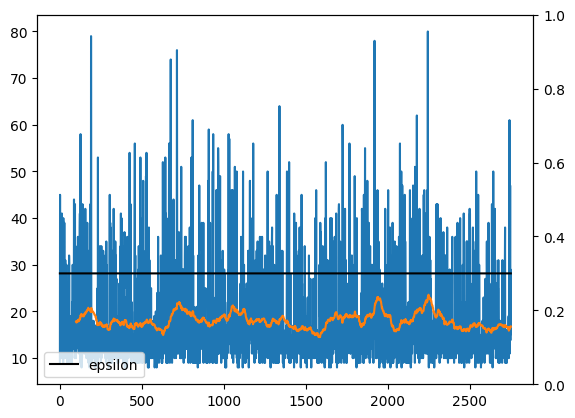

In [93]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 3000, learning=True, plot=True, target=400, target_window=100, plot_interval=250)

mean score 13.55


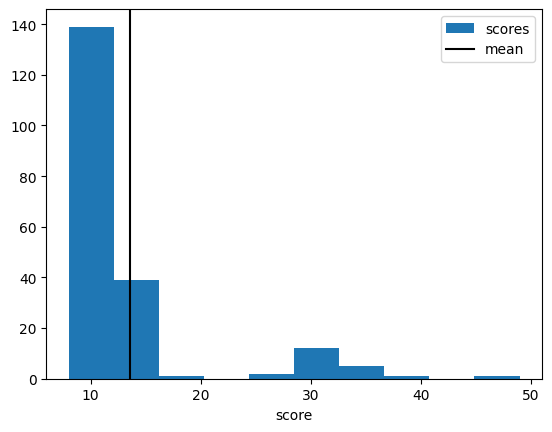

In [99]:
test_agent(env, agent, epochs=200)

## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [ ]:
class NeuralQLearningAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta
    
    def process_transition(self, observation, action, reward, next_observation, done):
        # Miejsce na Twoją implementację
        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację

In [ ]:
# Uczenie/testowania agenta
env = gym.make("LunarLander-v2")
agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=250)